## Introduction : Customer Lifetime Value

In today's digital age, e-commerce has revolutionized the way businesses operate, enabling transactions to occur seamlessly across borders and time zones. One such example is the UK-based non-store online retail sector, which has witnessed exponential growth in recent years. This growth has been fueled by technological advancements, changing consumer preferences, and the convenience offered by online shopping.

Among the myriad of online retailers, there exists a unique player - a company specializing in the sale of all-occasion gifts. Unlike traditional brick-and-mortar stores, this UK-based retailer operates solely through its online platform, catering to a diverse customer base both domestically and internationally. With a focus on providing unique and distinctive gifts, the company has carved a niche for itself in the competitive retail landscape.

The dataset under consideration provides a comprehensive view of all transactions conducted by this online retailer between the period of 01/12/2010 and 09/12/2011. Comprising over half a million instances, this dataset offers valuable insights into the dynamics of the company's operations, customer behavior, and market trends.

The main goal is to be able to predict customer lifetime value using two different methods. Beta Geometric/Negative Binomial Distribution and a feedforward Nerual Network.

In [3]:
import pandas as pd

In [4]:
df=pd.read_excel('Online Retail.xlsx')

In [5]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## Data Cleaning & Exploration

In [6]:
# Convert 'InvoiceDate' to date, drop null CustomerID, filter Quantity > 0, and calculate Revenue
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['CustomerID'] = df['CustomerID'].astype(int)
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Group by 'InvoiceDate', calculate total revenue and unique customer count, and rename columns
viz_df = df.groupby('InvoiceDate', as_index=False).agg({'Revenue': 'sum', 'CustomerID': 'nunique'})
viz_df.columns = ['InvoiceDate', 'TotalRevenue', 'CustomerCount']
viz_df['InvoiceDate'] = pd.to_datetime(viz_df['InvoiceDate'])

In [7]:
viz_df[['InvoiceDate']].min()

InvoiceDate   2010-12-01
dtype: datetime64[ns]

In [8]:
viz_df[['InvoiceDate']].max()

InvoiceDate   2011-12-09
dtype: datetime64[ns]

<Axes: xlabel='InvoiceDate'>

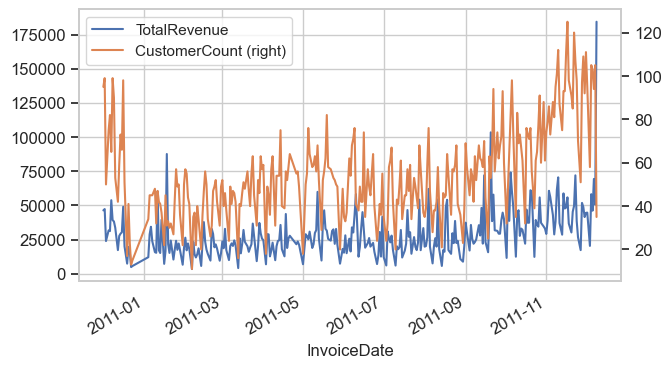

In [9]:
import matplotlib.pyplot as plt
viz_df.set_index('InvoiceDate', inplace=True)
viz_df.plot(figsize=(7,4),fontsize=12, secondary_y='CustomerCount')

In [10]:
from datetime import datetime
import numpy as np

date_rng = pd.date_range(start='2010-11-30', end='2011-11-30', freq='M')
churn =  {"Month":[],"ChurnRate":[], "AvgRevenue":[]}

#append first month without churn rate
this_period  =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['CustomerID'].unique()
total_revenue =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['Revenue'].sum()

churn["Month"].append(date_rng[1])
churn["ChurnRate"].append(np.nan)
churn["AvgRevenue"].append(int(total_revenue/len(this_period)))

#loop through the rest of the months
for i in range(len(date_rng)):
    try:
        last_period =df[(df['InvoiceDate']> date_rng[i].date()) & (df['InvoiceDate']<= date_rng[i+1].date()) ]['CustomerID'].unique()
        this_period  =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['CustomerID'].unique()
        total_revenue =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['Revenue'].sum()
        retained = np.intersect1d(last_period, this_period)
        churn["Month"].append(date_rng[i+2])
        churn["ChurnRate"].append((int((1-(len(retained)/len(last_period)))*100)))
        churn["AvgRevenue"].append(int(total_revenue/len(this_period)))
    except:
        pass

# Create churn_df DataFrame
churn_df = pd.DataFrame(churn)
churn_df

,Month,ChurnRate,AvgRevenue
0,2010-12-31,NaN,647
1,2011-01-31,63.0,768
2,2011-02-28,64.0,589
3,2011-03-31,61.0,611
4,2011-04-30,68.0,548
5,2011-05-31,57.0,642
6,2011-06-30,61.0,667
7,2011-07-31,63.0,632
8,2011-08-31,59.0,690
9,2011-09-30,54.0,752


In [11]:
churn_df.mean().round(0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_28004\694839836.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  churn_df.mean().round(0)


ChurnRate      60.0
AvgRevenue    667.0
dtype: float64

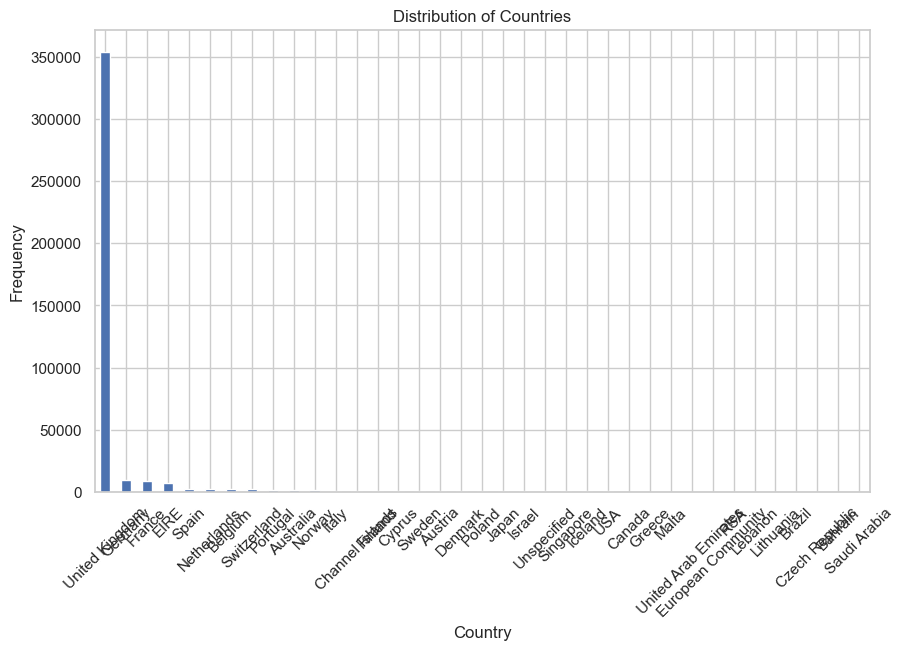

In [14]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
country_distribution = df['Country'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
country_distribution.plot(kind='bar')
plt.title('Distribution of Countries')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_28004\3764383645.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


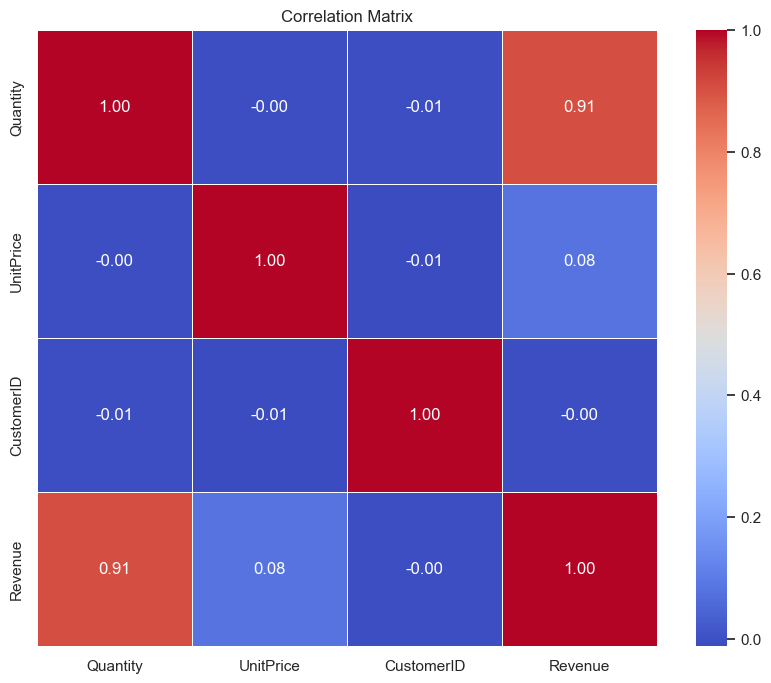

In [13]:
# Explore correlations between numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Modeling Customer Behavior Over Time

The BG/NBD model, short for Beta Geometric/Negative Binomial Distribution, was pioneered by Fader et al. in 2005. It's a sophisticated probabilistic model designed to accurately describe customer purchase behavior over time. This model employs four key parameters to effectively capture the underlying distributions:

Beta Distribution (B): This component models the probability of a customer being "alive" (i.e., still engaged with the business) over time. It combines aspects of geometric distribution, which deals with the number of trials until the first success, and beta distribution, which represents probabilities between 0 and 1.

Geometric Distribution (G): This distribution is incorporated into the BG/NBD model to capture the probability of a customer becoming inactive after a certain period of time.

Negative Binomial Distribution (NBD): The NBD component models the probability of a customer making a purchase during a given unit of time. It blends aspects of Poisson distribution, which models the number of events occurring within fixed intervals, and gamma distribution, which represents continuous positive values.

The BG/NBD model's fitting process involves optimizing these parameters to best fit the observed customer purchase data.

In addition to the BG/NBD model, there are other probabilistic models available for analyzing customer behavior, such as:

Pareto/NBD: This model is based on the Pareto principle, also known as the 80/20 rule, which suggests that a small proportion of customers (the "vital few") contribute the majority of revenue. The Pareto/NBD model extends the NBD framework to account for this phenomenon.

BG/BB: The BG/BB model, or Beta Geometric/Beta Binomial model, is another probabilistic model used for customer base analysis. It combines elements of the beta distribution for modeling customer "alive" probabilities with the beta binomial distribution for modeling purchase behavior variability among customers.

Each of these models offers unique insights into customer dynamics and can be applied depending on the specific characteristics of the business and its customer base.

In [10]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate',\
          monetary_value_col='Revenue', observation_period_end='2011-09-01')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,226.0,0.0000
12347,4.0,238.0,268.0,519.7675
12348,2.0,110.0,259.0,297.2200
12350,0.0,0.0,211.0,0.0000
12352,3.0,34.0,197.0,421.7700


In [11]:
cutoff_date = pd.to_datetime("2011-09-01").date()
end_date = pd.to_datetime("2011-12-01").date()

true_df = pd.DataFrame(df.loc[(df['InvoiceDate']>=cutoff_date)\
                              &(df['InvoiceDate']<end_date)]\
                       .groupby('CustomerID')['Revenue'].sum()).reset_index()

train_df = data.reset_index().merge(true_df).rename(columns={"Revenue":"y"})
train_df

,CustomerID,frequency,recency,T,monetary_value,y
0,12347,4.0,238.0,268.0,519.767500,1294.32
1,12348,2.0,110.0,259.0,297.220000,310.00
2,12352,3.0,34.0,197.0,421.770000,944.23
3,12356,1.0,80.0,226.0,481.460000,58.35
4,12359,2.0,142.0,232.0,1474.115000,2876.85
...,...,...,...,...,...,...
1873,18270,0.0,0.0,167.0,0.000000,171.20
1874,18272,3.0,133.0,147.0,488.876667,604.25
1875,18273,0.0,0.0,158.0,0.000000,102.00
1876,18283,7.0,189.0,238.0,125.331429,901.11


In [12]:
from lifetimes import BetaGeoFitter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df[['CustomerID',\
                           'frequency','recency', 'T','monetary_value']],\
                           train_df[['y']], test_size=0.3, random_state=42)

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(X_train['frequency'], X_train['recency'], X_train['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1314 subjects, a: 0.00, alpha: 44.90, b: 0.00, r: 0.72>


In [13]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
15311,61.0,261.0,274.0,732.480164,0.193551
14606,64.0,270.0,274.0,142.672812,0.202959
12748,69.0,272.0,274.0,196.573913,0.218638
17841,73.0,274.0,274.0,303.863699,0.231181
14911,80.0,274.0,274.0,972.027875,0.253132


In [14]:
data['predicted_alive'] = bgf.conditional_probability_alive(data['frequency'],
                                                  data['recency'], data['T'])
data.sort_values(by='predicted_alive').head(5)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_alive
CustomerID,,,,,,
17850,1.0,1.0,274.0,3891.87,0.005402,1.0
15332,1.0,3.0,270.0,63.00,0.005471,1.0
16499,1.0,4.0,265.0,147.35,0.005559,1.0
15224,1.0,4.0,263.0,310.48,0.005595,1.0
17198,1.0,6.0,272.0,249.65,0.005436,1.0


In [15]:
returning_customers_summary = X_train[X_train['frequency']>0]
print(returning_customers_summary.head())

      CustomerID  frequency  recency      T  monetary_value
1754       17838        2.0     80.0  273.0      485.270000
798        14715        1.0     33.0  232.0      109.500000
1820       18102       14.0    241.0  268.0     7472.632857
1469       16912        3.0    189.0  224.0      393.693333
58         12480        2.0    193.0  237.0      664.350000


In [16]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 961 subjects, p: 3.18, q: 3.20, v: 302.83>


In [18]:
pred = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    X_test['frequency'],
    X_test['recency'],
    X_test['T'],
    X_test['monetary_value'],
    time=3, # months
    discount_rate=0 # monthly discount rate ~ 12.7% annually
).fillna(0)

pred

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1111     175.167450
1448    2290.274120
1326     190.359216
807     1082.636798
270      336.737655
           ...     
1734     106.115523
358      107.717899
1041      89.477544
236      138.584806
551      154.324949
Name: clv, Length: 564, dtype: float64

In [21]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 805.323044194314


## 2nd Model using Tensorflow

The aim is to use Tensorflow to examine the effect of adjusting various hidden layer neurons to determine if there is any obvious trend with regards to the determination of it's impact on the predictions.

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kerastuner as kt
import matplotlib.pyplot as plt

In [46]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [125]:
# Define a function to build the model
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32),
                    activation=hp.Choice('activation_input', values=['relu', 'tanh', 'sigmoid']),
                    input_shape=(X_train_scaled.shape[1],)))
    
    # Hidden layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                        activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid'])))
    
    # Output layer
    model.add(Dense(1))  # Output layer, no activation function for regression
    
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mean_squared_error',
                  metrics=['mse'])
    
    return model


# Instantiate a tuner
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [126]:
# Perform hyperparameter search
tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [131]:
# Lists to store train and validation loss for all trials
train_loss_per_trial = []
val_loss_per_trial = []

# Loop over all trials
for trial in tuner.oracle.get_best_trials(num_trials=10):  # Change num_trials as needed
    # Build the model with the current trial's hyperparameters
    model = tuner.hypermodel.build(trial.hyperparameters)
    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2)
    # Store train and validation loss
    train_loss_per_trial.append(history.history['loss'])
    val_loss_per_trial.append(history.history['val_loss'])

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18741778.0000 - mse: 18748822.0000 - val_loss: 107155880.0000 - val_mse: 64441968.0000
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16932340.0000 - mse: 16937812.0000 - val_loss: 107136936.0000 - val_mse: 64433520.0000
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44474656.0000 - mse: 44481528.0000 - val_loss: 107102192.0000 - val_mse: 64418012.0000
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21149178.0000 - mse: 21156056.0000 - val_loss: 107045216.0000 - val_mse: 64391428.0000
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19923498.0000 - mse: 19930732.0000 - val_loss: 106961376.0000 - val_mse: 64350648.0000
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8798417.0000 - mse: 8707276.0000 - val_loss: 106835624.0000 - val_mse: 64289700.0000
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20119196.0000 - mse: 20126074.0000 - val_loss: 106628552.0000 - val

Epoch 92/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18700058.0000 - mse: 18704040.0000 - val_loss: 53303664.0000 - val_mse: 37508652.0000
Epoch 93/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20799108.0000 - mse: 20802920.0000 - val_loss: 53210112.0000 - val_mse: 37414252.0000
Epoch 94/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7230144.5000 - mse: 7233979.0000 - val_loss: 52826000.0000 - val_mse: 37208528.0000
Epoch 95/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5255273.5000 - mse: 5258707.0000 - val_loss: 52524860.0000 - val_mse: 37028204.0000
Epoch 96/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12805447.0000 - mse: 12807213.0000 - val_loss: 51893020.0000 - val_mse: 36685196.0000
Epoch 97/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27544514.0000 - mse: 27548272.0000 - val_loss: 51370324.0000 - val_mse: 36403788.0000
Epoch 98/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10049853.0000 - mse: 10053429.0000 - val_loss: 51165392.0000 - val_m

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8084044.5000 - mse: 8086707.5000 - val_loss: 34258084.0000 - val_mse: 25146680.0000
Epoch 183/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10566434.0000 - mse: 10568863.0000 - val_loss: 34164256.0000 - val_mse: 25057306.0000
Epoch 184/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9622965.0000 - mse: 9624322.0000 - val_loss: 34278884.0000 - val_mse: 25108294.0000
Epoch 185/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15677706.0000 - mse: 15680296.0000 - val_loss: 33984976.0000 - val_mse: 24928086.0000
Epoch 186/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9238662.0000 - mse: 9240447.0000 - val_loss: 33879812.0000 - val_mse: 24865746.0000
Epoch 187/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7345207.5000 - mse: 7347932.5000 - val_loss: 34067232.0000 - val_mse: 24928876.0000
Epoch 188/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15843791.0000 - mse: 15846353.0000 - val_loss: 33897888.0000 - val_mse: 2481659

Epoch 73/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11624361.0000 - mse: 11628537.0000 - val_loss: 64674916.0000 - val_mse: 43316112.0000
Epoch 74/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13829170.0000 - mse: 13833640.0000 - val_loss: 64205156.0000 - val_mse: 43059792.0000
Epoch 75/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33900892.0000 - mse: 33905452.0000 - val_loss: 63659364.0000 - val_mse: 42774800.0000
Epoch 76/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27575068.0000 - mse: 27578916.0000 - val_loss: 63243804.0000 - val_mse: 42542416.0000
Epoch 77/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7156272.0000 - mse: 7160543.0000 - val_loss: 63053596.0000 - val_mse: 42423460.0000
Epoch 78/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18306800.0000 - mse: 18310934.0000 - val_loss: 62481236.0000 - val_mse: 42128116.0000
Epoch 79/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27653282.0000 - mse: 27657214.0000 - val_loss: 62087892.0000 - val

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4033755.7500 - mse: 4007411.0000 - val_loss: 38236288.0000 - val_mse: 27708380.0000
Epoch 164/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15438313.0000 - mse: 15441171.0000 - val_loss: 37671952.0000 - val_mse: 27418304.0000
Epoch 165/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8288020.0000 - mse: 8290788.5000 - val_loss: 37587664.0000 - val_mse: 27345684.0000
Epoch 166/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7971213.5000 - mse: 7972306.5000 - val_loss: 37559260.0000 - val_mse: 27303746.0000
Epoch 167/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10867108.0000 - mse: 10869623.0000 - val_loss: 37258176.0000 - val_mse: 27127896.0000
Epoch 168/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11920975.0000 - mse: 11923565.0000 - val_loss: 37257040.0000 - val_mse: 27105794.0000
Epoch 169/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17143416.0000 - mse: 17145416.0000 - val_loss: 36999040.0000 - val_mse: 26949

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13842036.0000 - mse: 13840985.0000 - val_loss: 73399256.0000 - val_mse: 47914624.0000
Epoch 54/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29134478.0000 - mse: 29139558.0000 - val_loss: 72873032.0000 - val_mse: 47663440.0000
Epoch 55/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27663450.0000 - mse: 27668342.0000 - val_loss: 72426296.0000 - val_mse: 47442932.0000
Epoch 56/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13007341.0000 - mse: 13012144.0000 - val_loss: 71775320.0000 - val_mse: 47123832.0000
Epoch 57/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16136644.0000 - mse: 16141041.0000 - val_loss: 71280472.0000 - val_mse: 46876876.0000
Epoch 58/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15591853.0000 - mse: 15596807.0000 - val_loss: 70708704.0000 - val_mse: 46600044.0000
Epoch 59/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8026421.5000 - mse: 8030586.0000 - val_loss: 70425968.0000 - val_mse: 4644751

Epoch 99/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20691810.0000 - mse: 20695624.0000 - val_loss: 53498020.0000 - val_mse: 37420384.0000
Epoch 100/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29894782.0000 - mse: 29898450.0000 - val_loss: 53091136.0000 - val_mse: 37199028.0000
Epoch 101/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13695578.0000 - mse: 13699348.0000 - val_loss: 52941900.0000 - val_mse: 37082476.0000
Epoch 102/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4016146.0000 - mse: 3931330.5000 - val_loss: 52893140.0000 - val_mse: 37032008.0000
Epoch 103/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6844534.5000 - mse: 6848450.5000 - val_loss: 52251628.0000 - val_mse: 36693076.0000
Epoch 104/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15008789.0000 - mse: 15012359.0000 - val_loss: 51692316.0000 - val_mse: 36394516.0000
Epoch 105/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19468044.0000 - mse: 19471496.0000 - val_loss: 51325272.0000 -

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19308522.0000 - mse: 19311310.0000 - val_loss: 35225812.0000 - val_mse: 25738074.0000
Epoch 190/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14630167.0000 - mse: 14632988.0000 - val_loss: 35274296.0000 - val_mse: 25732532.0000
Epoch 191/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13765210.0000 - mse: 13767289.0000 - val_loss: 35023056.0000 - val_mse: 25598794.0000
Epoch 192/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8255722.5000 - mse: 8231475.5000 - val_loss: 35170360.0000 - val_mse: 25636688.0000
Epoch 193/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10417288.0000 - mse: 10420132.0000 - val_loss: 34877040.0000 - val_mse: 25475334.0000
Epoch 194/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10424814.0000 - mse: 10427451.0000 - val_loss: 34717496.0000 - val_mse: 25374884.0000
Epoch 195/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11552487.0000 - mse: 11555065.0000 - val_loss: 34681948.0000 - val_mse: 2

Epoch 80/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25675284.0000 - mse: 25679366.0000 - val_loss: 60969748.0000 - val_mse: 41229408.0000
Epoch 81/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17899060.0000 - mse: 17903316.0000 - val_loss: 60495568.0000 - val_mse: 40969740.0000
Epoch 82/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9515212.0000 - mse: 9519358.0000 - val_loss: 60295360.0000 - val_mse: 40837012.0000
Epoch 83/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3028240.0000 - mse: 2881070.7500 - val_loss: 60281620.0000 - val_mse: 40798104.0000
Epoch 84/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6995113.0000 - mse: 6999097.5000 - val_loss: 59418092.0000 - val_mse: 40357112.0000
Epoch 85/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9490245.0000 - mse: 9493255.0000 - val_loss: 58826348.0000 - val_mse: 40054268.0000
Epoch 86/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5156854.0000 - mse: 5160612.0000 - val_loss: 58666072.0000 - val_mse: 39

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7168830.0000 - mse: 7169383.5000 - val_loss: 37446532.0000 - val_mse: 27145654.0000
Epoch 171/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6419250.0000 - mse: 6418249.0000 - val_loss: 37285288.0000 - val_mse: 27039820.0000
Epoch 172/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7663410.5000 - mse: 7666249.5000 - val_loss: 37172944.0000 - val_mse: 26955238.0000
Epoch 173/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12813389.0000 - mse: 12816001.0000 - val_loss: 36874788.0000 - val_mse: 26785848.0000
Epoch 174/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8008033.0000 - mse: 8010588.0000 - val_loss: 36974224.0000 - val_mse: 26794410.0000
Epoch 175/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4298819.0000 - mse: 4301737.5000 - val_loss: 37073252.0000 - val_mse: 26825012.0000
Epoch 176/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7003550.5000 - mse: 7005835.5000 - val_loss: 36693432.0000 - val_mse: 26621174.00

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14123613.0000 - mse: 14128536.0000 - val_loss: 70046072.0000 - val_mse: 45803052.0000
Epoch 61/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15682411.0000 - mse: 15687330.0000 - val_loss: 69617880.0000 - val_mse: 45571108.0000
Epoch 62/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7696112.5000 - mse: 7700939.0000 - val_loss: 69249320.0000 - val_mse: 45378236.0000
Epoch 63/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14279686.0000 - mse: 14284104.0000 - val_loss: 68557664.0000 - val_mse: 45027504.0000
Epoch 64/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16678999.0000 - mse: 16683558.0000 - val_loss: 68033592.0000 - val_mse: 44758628.0000
Epoch 65/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25043484.0000 - mse: 24940894.0000 - val_loss: 67885656.0000 - val_mse: 44663344.0000
Epoch 66/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20537600.0000 - mse: 20541688.0000 - val_loss: 67111408.0000 - val_mse: 4426182

Epoch 106/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5974980.0000 - mse: 5978476.5000 - val_loss: 51055344.0000 - val_mse: 35300184.0000
Epoch 107/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9276520.0000 - mse: 9279934.0000 - val_loss: 50482488.0000 - val_mse: 34984824.0000
Epoch 108/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6566580.0000 - mse: 6569652.0000 - val_loss: 50255560.0000 - val_mse: 34837324.0000
Epoch 109/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8222417.0000 - mse: 8225464.0000 - val_loss: 49995660.0000 - val_mse: 34669092.0000
Epoch 110/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10206486.0000 - mse: 10209628.0000 - val_loss: 49451744.0000 - val_mse: 34379264.0000
Epoch 111/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7299210.0000 - mse: 7301408.0000 - val_loss: 49380792.0000 - val_mse: 34318600.0000
Epoch 112/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13825190.0000 - mse: 13826260.0000 - val_loss: 48853048.0000 - val_

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6004738.5000 - mse: 6005017.5000 - val_loss: 34097568.0000 - val_mse: 24583846.0000
Epoch 197/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18350648.0000 - mse: 18353084.0000 - val_loss: 34041152.0000 - val_mse: 24523812.0000
Epoch 198/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22394852.0000 - mse: 22395484.0000 - val_loss: 33754564.0000 - val_mse: 24373714.0000
Epoch 199/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6948207.0000 - mse: 6948747.0000 - val_loss: 33775068.0000 - val_mse: 24369060.0000
Epoch 200/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10388043.0000 - mse: 10390548.0000 - val_loss: 33639936.0000 - val_mse: 24287864.0000
Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 18731802.0000 - mse: 18650808.0000 - val_loss: 107169712.0000 - val_mse: 64444368.0000
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9185239.0000 - mse: 9191976.0000 - val_loss: 107150208.0000 - val_mse: 6443369

Epoch 87/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14758956.0000 - mse: 14763190.0000 - val_loss: 57216320.0000 - val_mse: 39602196.0000
Epoch 88/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14494449.0000 - mse: 14498469.0000 - val_loss: 56880120.0000 - val_mse: 39407564.0000
Epoch 89/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11939613.0000 - mse: 11943799.0000 - val_loss: 56683988.0000 - val_mse: 39276376.0000
Epoch 90/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21509964.0000 - mse: 21513152.0000 - val_loss: 56278956.0000 - val_mse: 39068664.0000
Epoch 91/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13632803.0000 - mse: 13636746.0000 - val_loss: 55878112.0000 - val_mse: 38831960.0000
Epoch 92/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14039995.0000 - mse: 14043558.0000 - val_loss: 55407724.0000 - val_mse: 38579708.0000
Epoch 93/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10814006.0000 - mse: 10817564.0000 - val_loss: 54979312.0000 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12822222.0000 - mse: 12824861.0000 - val_loss: 35742956.0000 - val_mse: 26258424.0000
Epoch 178/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6262576.5000 - mse: 6263624.5000 - val_loss: 35681076.0000 - val_mse: 26205510.0000
Epoch 179/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7950481.0000 - mse: 7953259.0000 - val_loss: 35533148.0000 - val_mse: 26113402.0000
Epoch 180/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5207294.5000 - mse: 5209886.5000 - val_loss: 35550576.0000 - val_mse: 26094358.0000
Epoch 181/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6104641.5000 - mse: 6106732.0000 - val_loss: 35472716.0000 - val_mse: 26027012.0000
Epoch 182/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11214518.0000 - mse: 11216329.0000 - val_loss: 35447012.0000 - val_mse: 25992858.0000
Epoch 183/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15383134.0000 - mse: 15385883.0000 - val_loss: 35244136.0000 - val_mse: 2585414

Epoch 68/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22948252.0000 - mse: 22952548.0000 - val_loss: 61975680.0000 - val_mse: 41701884.0000
Epoch 69/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9985986.0000 - mse: 9990203.0000 - val_loss: 61747328.0000 - val_mse: 41567960.0000
Epoch 70/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17647588.0000 - mse: 17651610.0000 - val_loss: 61134848.0000 - val_mse: 41253168.0000
Epoch 71/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21174954.0000 - mse: 21179282.0000 - val_loss: 60763628.0000 - val_mse: 41026820.0000
Epoch 72/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16009693.0000 - mse: 16013804.0000 - val_loss: 60087152.0000 - val_mse: 40686488.0000
Epoch 73/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26523650.0000 - mse: 26527692.0000 - val_loss: 59648340.0000 - val_mse: 40444176.0000
Epoch 74/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9606802.0000 - mse: 9611010.0000 - val_loss: 59290104.0000 - val_m

Epoch 114/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14539398.0000 - mse: 14542650.0000 - val_loss: 44159844.0000 - val_mse: 31603820.0000
Epoch 115/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11856319.0000 - mse: 11859447.0000 - val_loss: 43929044.0000 - val_mse: 31455266.0000
Epoch 116/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9373689.0000 - mse: 9376742.0000 - val_loss: 43812752.0000 - val_mse: 31365450.0000
Epoch 117/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12278543.0000 - mse: 12279962.0000 - val_loss: 43362116.0000 - val_mse: 31099732.0000
Epoch 118/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6584764.0000 - mse: 6587911.0000 - val_loss: 43202820.0000 - val_mse: 31002700.0000
Epoch 119/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8625578.0000 - mse: 8628502.0000 - val_loss: 42970952.0000 - val_mse: 30846554.0000
Epoch 120/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6147360.5000 - mse: 6150587.0000 - val_loss: 42837780.0000 - va

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18628070.0000 - mse: 18635084.0000 - val_loss: 107104184.0000 - val_mse: 64410196.0000
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17674932.0000 - mse: 17681408.0000 - val_loss: 107055216.0000 - val_mse: 64383292.0000
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18347586.0000 - mse: 18354386.0000 - val_loss: 106982416.0000 - val_mse: 64342952.0000
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22594554.0000 - mse: 22600026.0000 - val_loss: 106876944.0000 - val_mse: 64283528.0000
Epoch 8/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14064731.0000 - mse: 14071060.0000 - val_loss: 106718944.0000 - val_mse: 64196016.0000
Epoch 9/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20432518.0000 - mse: 20439472.0000 - val_loss: 106505288.0000 - val_mse: 64076880.0000
Epoch 10/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29206520.0000 - mse: 29213450.0000 - val_loss: 106215464.0000 - val_mse: 639

Epoch 95/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31157440.0000 - mse: 31161330.0000 - val_loss: 52770284.0000 - val_mse: 37002528.0000
Epoch 96/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6937426.0000 - mse: 6941027.5000 - val_loss: 52647856.0000 - val_mse: 36909320.0000
Epoch 97/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16296545.0000 - mse: 16300345.0000 - val_loss: 52076656.0000 - val_mse: 36606252.0000
Epoch 98/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6622632.5000 - mse: 6626229.0000 - val_loss: 51945520.0000 - val_mse: 36510208.0000
Epoch 99/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22189040.0000 - mse: 22192252.0000 - val_loss: 51351340.0000 - val_mse: 36189656.0000
Epoch 100/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21893128.0000 - mse: 21896638.0000 - val_loss: 51066728.0000 - val_mse: 36011952.0000
Epoch 101/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13400956.0000 - mse: 13402703.0000 - val_loss: 50714012.0000 - val

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9939512.0000 - mse: 9942110.0000 - val_loss: 34639688.0000 - val_mse: 25342228.0000
Epoch 186/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18740340.0000 - mse: 18739926.0000 - val_loss: 34330928.0000 - val_mse: 25177934.0000
Epoch 187/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6042339.0000 - mse: 6043583.5000 - val_loss: 34630620.0000 - val_mse: 25296226.0000
Epoch 188/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4166800.5000 - mse: 4168753.2500 - val_loss: 34606088.0000 - val_mse: 25251566.0000
Epoch 189/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3571920.2500 - mse: 3574466.2500 - val_loss: 34679524.0000 - val_mse: 25260904.0000
Epoch 190/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7353392.0000 - mse: 7356050.5000 - val_loss: 34423996.0000 - val_mse: 25106166.0000
Epoch 191/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11842506.0000 - mse: 11844155.0000 - val_loss: 34211064.0000 - val_mse: 24982510.

Epoch 76/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21823884.0000 - mse: 21827988.0000 - val_loss: 60105720.0000 - val_mse: 41144828.0000
Epoch 77/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20457052.0000 - mse: 20458230.0000 - val_loss: 59627884.0000 - val_mse: 40890144.0000
Epoch 78/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20063618.0000 - mse: 20067658.0000 - val_loss: 59199048.0000 - val_mse: 40651968.0000
Epoch 79/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19143116.0000 - mse: 19146570.0000 - val_loss: 58774572.0000 - val_mse: 40417392.0000
Epoch 80/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10658657.0000 - mse: 10662774.0000 - val_loss: 58334556.0000 - val_mse: 40180944.0000
Epoch 81/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10003861.0000 - mse: 10007967.0000 - val_loss: 58090688.0000 - val_mse: 40018332.0000
Epoch 82/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6112567.0000 - mse: 6112767.5000 - val_loss: 57681828.0000 - val

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6380897.0000 - mse: 6383210.5000 - val_loss: 35824640.0000 - val_mse: 26189788.0000
Epoch 167/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8040998.5000 - mse: 8043817.5000 - val_loss: 35642512.0000 - val_mse: 26071394.0000
Epoch 168/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9256803.0000 - mse: 9258406.0000 - val_loss: 35460016.0000 - val_mse: 25948224.0000
Epoch 169/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12898395.0000 - mse: 12900804.0000 - val_loss: 35274340.0000 - val_mse: 25840440.0000
Epoch 170/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8627928.0000 - mse: 8630674.0000 - val_loss: 35472812.0000 - val_mse: 25917276.0000
Epoch 171/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18629494.0000 - mse: 18632268.0000 - val_loss: 34990832.0000 - val_mse: 25629162.0000
Epoch 172/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13704369.0000 - mse: 13705019.0000 - val_loss: 34982848.0000 - val_mse: 2561560

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23564384.0000 - mse: 23507720.0000 - val_loss: 68450784.0000 - val_mse: 45351856.0000
Epoch 57/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14517659.0000 - mse: 14522472.0000 - val_loss: 67702216.0000 - val_mse: 44994092.0000
Epoch 58/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16787656.0000 - mse: 16791888.0000 - val_loss: 67028892.0000 - val_mse: 44664400.0000
Epoch 59/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10398868.0000 - mse: 10403363.0000 - val_loss: 66676336.0000 - val_mse: 44472640.0000
Epoch 60/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15603071.0000 - mse: 15604132.0000 - val_loss: 66252132.0000 - val_mse: 44242288.0000
Epoch 61/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30093372.0000 - mse: 30097602.0000 - val_loss: 65533880.0000 - val_mse: 43893060.0000
Epoch 62/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16930260.0000 - mse: 16934982.0000 - val_loss: 65084856.0000 - val_mse: 43657

Epoch 102/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17974372.0000 - mse: 17976842.0000 - val_loss: 48192112.0000 - val_mse: 34278180.0000
Epoch 103/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11937544.0000 - mse: 11940926.0000 - val_loss: 48205760.0000 - val_mse: 34248692.0000
Epoch 104/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7590893.5000 - mse: 7594242.5000 - val_loss: 47746576.0000 - val_mse: 33985580.0000
Epoch 105/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9710181.0000 - mse: 9713343.0000 - val_loss: 47365120.0000 - val_mse: 33763024.0000
Epoch 106/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18318842.0000 - mse: 18320292.0000 - val_loss: 46970504.0000 - val_mse: 33527890.0000
Epoch 107/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5088363.5000 - mse: 5091851.5000 - val_loss: 46976860.0000 - val_mse: 33490006.0000
Epoch 108/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12997213.0000 - mse: 12999911.0000 - val_loss: 46377248.0000 - 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12916369.0000 - mse: 12919000.0000 - val_loss: 32975314.0000 - val_mse: 24014232.0000
Epoch 193/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14618733.0000 - mse: 14620681.0000 - val_loss: 32945088.0000 - val_mse: 23985296.0000
Epoch 194/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6234149.0000 - mse: 6236575.0000 - val_loss: 33163306.0000 - val_mse: 24073900.0000
Epoch 195/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5939004.0000 - mse: 5941101.0000 - val_loss: 33194056.0000 - val_mse: 24076000.0000
Epoch 196/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5375555.5000 - mse: 5378172.5000 - val_loss: 33116630.0000 - val_mse: 24014364.0000
Epoch 197/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5385307.5000 - mse: 5387063.0000 - val_loss: 32953784.0000 - val_mse: 23914542.0000
Epoch 198/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6011139.0000 - mse: 6013285.5000 - val_loss: 32899844.0000 - val_mse: 23878890.

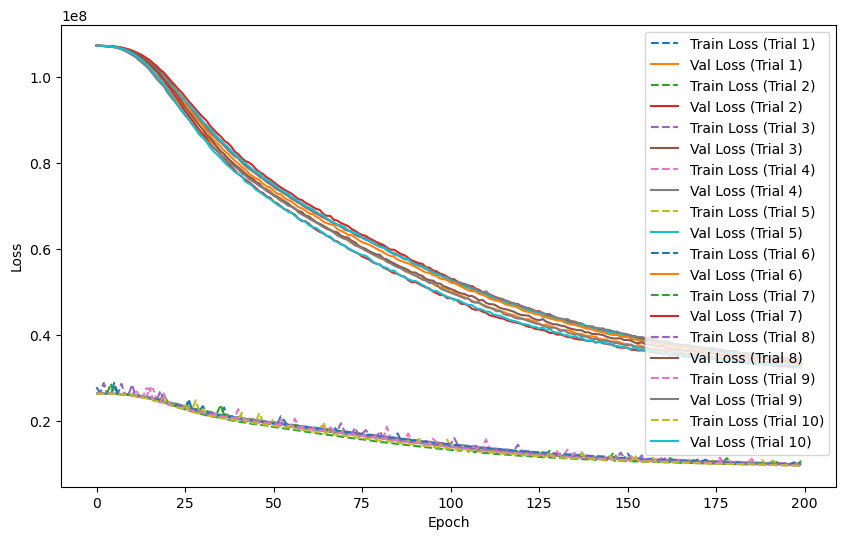

In [132]:
# Plot the loss over time for all trials
plt.figure(figsize=(10, 6))
for i in range(len(train_loss_per_trial)):
    plt.plot(train_loss_per_trial[i], label=f'Train Loss (Trial {i+1})', linestyle='--')
    plt.plot(val_loss_per_trial[i], label=f'Val Loss (Trial {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [133]:
# Loop over all trials and print the number of neurons for each trial
for i, trial in enumerate(tuner.oracle.get_best_trials(num_trials=10)):  # Change num_trials as needed
    print(f"Trial {i+1}: Number of neurons - {trial.hyperparameters.values['units']}")


Trial 1: Number of neurons - 480
Trial 2: Number of neurons - 512
Trial 3: Number of neurons - 480
Trial 4: Number of neurons - 416
Trial 5: Number of neurons - 512
Trial 6: Number of neurons - 448
Trial 7: Number of neurons - 384
Trial 8: Number of neurons - 288
Trial 9: Number of neurons - 256
Trial 10: Number of neurons - 480


In [134]:
# Loop over all trials and print the architecture for each trial
for i, trial in enumerate(tuner.oracle.get_best_trials(num_trials=10)):  # Change num_trials as needed
    print(f"Trial {i+1} Architecture:")
    print("Input layer: Number of neurons -", X_train_scaled.shape[1])
    print("Hidden layer 1: Number of neurons -", trial.hyperparameters.values['units'])
    print("Hidden layer 2: Number of neurons -", trial.hyperparameters.values['units'])
    print("Output layer: Number of neurons - 1")
    print()


Trial 1 Architecture:
Input layer: Number of neurons - 5
Hidden layer 1: Number of neurons - 480
Hidden layer 2: Number of neurons - 480
Output layer: Number of neurons - 1

Trial 2 Architecture:
Input layer: Number of neurons - 5
Hidden layer 1: Number of neurons - 512
Hidden layer 2: Number of neurons - 512
Output layer: Number of neurons - 1

Trial 3 Architecture:
Input layer: Number of neurons - 5
Hidden layer 1: Number of neurons - 480
Hidden layer 2: Number of neurons - 480
Output layer: Number of neurons - 1

Trial 4 Architecture:
Input layer: Number of neurons - 5
Hidden layer 1: Number of neurons - 416
Hidden layer 2: Number of neurons - 416
Output layer: Number of neurons - 1

Trial 5 Architecture:
Input layer: Number of neurons - 5
Hidden layer 1: Number of neurons - 512
Hidden layer 2: Number of neurons - 512
Output layer: Number of neurons - 1

Trial 6 Architecture:
Input layer: Number of neurons - 5
Hidden layer 1: Number of neurons - 448
Hidden layer 2: Number of neurons

## Conclusion

Through our exploration, a notable observation has emerged: networks with more hidden layers often exhibit faster training times and achieve lower validation loss. This can be seen with trials 10 and 2. This phenomenon underscores the importance of network depth in capturing complex patterns within data, allowing for more efficient and accurate learning.

The advantage of deeper architectures lies in their ability to hierarchically represent abstract features, enabling the network to learn intricate relationships between input and output. As information propagates through successive layers, each layer extracts increasingly sophisticated representations, leading to enhanced model performance.

Furthermore, the efficiency gained from deeper networks can be attributed to the distribution of computational load across multiple layers, facilitating parallel processing and accelerating convergence during training. This distributed computation enables the network to efficiently navigate complex optimization landscapes, resulting in faster convergence towards optimal solutions.

Thus, these two methods are valid ways in order to forecast Customer Lifetime Value.